<a href="https://colab.research.google.com/github/Kolo-Naukowe-Axion/QC1/blob/ansatz/ansatz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Optional: Install dependencies if not already present
INSTALL_DEPS = True

if INSTALL_DEPS:
    import sys
    import subprocess

    packages = [
        'numpy',
        'scikit-learn',
        'ucimlrepo',
        'qiskit',
        'qiskit-machine-learning',
        'torch',
        'matplotlib'
    ]

    for pkg in packages:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])

In [2]:
# Standard library
import random

# Scientific computing
import numpy as np
import matplotlib.pyplot as plt
import csv

# Machine learning
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from ucimlrepo import fetch_ucirepo

# Quantum computing
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN


In [3]:
def set_random_seed(seed: int = 42) -> None:
    """
    Set random seeds for reproducibility across numpy, PyTorch, and Python's random module.

    Parameters
    ----------
    seed : int
        Random seed value (default: 42)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Set global seed
RANDOM_SEED = 42
set_random_seed(RANDOM_SEED)

In [4]:
def prepare_data(test_size: float = 0.2, random_state: int = 42):
    # Fetch dataset from UCI repository
    banknote_authentication = fetch_ucirepo(id=267)
    X = banknote_authentication.data.features.to_numpy()
    y = banknote_authentication.data.targets.to_numpy().ravel()

    indices = np.arange(len(X))

    # Sanity checks
    assert X.shape[1] == 4, f"Expected 4 features, got {X.shape[1]}"
    assert set(np.unique(y)) == {0, 1}, f"Expected binary labels {{0, 1}}, got {set(np.unique(y))}"

    # Feature engineering: interaction term
    variance = X[:, 0].reshape(-1, 1)
    skewness = X[:, 1].reshape(-1, 1)
    interaction = variance * skewness
    X_expanded = np.hstack((X, interaction))

    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X_expanded, y, indices, test_size=test_size, random_state=random_state
    )

    # Scale features to [0, π] for angle encoding
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Dataset loaded: {len(X_train)} train, {len(X_test)} test samples")
    print(f"Feature dimension: {X_train_scaled.shape[1]}")

    return X_train_scaled, X_test_scaled, y_train, y_test, idx_train, idx_test

In [5]:
def ansatz(n_qubits, depth):
    """
    Ansatz with Ring topology.
    Uses exclusively native-like gates: Rx, Ry, Rz, and Cz.
    No Hadamard or CX gates are used.
    """
    # For each full iteration (2 layers):
    # Layer 1: n_qubits (Ry) + n_qubits (Rz before Cz)
    # Layer 2: n_qubits (Rx) + n_qubits (Ry before Cz)
    # Total: 4 * n_qubits per iteration (depth // 2 iterations)
    params_per_iter = 4 * n_qubits
    theta = ParameterVector('θ', params_per_iter * (depth // 2))

    qc = QuantumCircuit(n_qubits)

    for j in range(depth // 2):
        offset = j * params_per_iter

        # -------- Layer 1: Ry + Ring Cz (with Rz) --------

        # 1. Independent Ry rotations
        for i in range(n_qubits):
            qc.ry(theta[offset + i], i)

        # 2. Ring entanglement (0-1, 1-2, ..., n-1-0)
        # Each pair: Rz on target + Cz
        for i in range(n_qubits):
            control = i
            target = (i + 1) % n_qubits

            param_idx = offset + n_qubits + i
            qc.rz(theta[param_idx], target)
            qc.cz(control, target)

        # -------- Layer 2: Rx + Ring Cz (with Ry) --------

        offset_l2 = offset + 2 * n_qubits

        # 1. Independent Rx rotations
        for i in range(n_qubits):
            qc.rx(theta[offset_l2 + i], i)

        # 2. Reverse ring entanglement (or shifted)
        # Each pair: Ry on target + Cz
        for i in range(n_qubits):
            control = i
            target = (i - 1) % n_qubits

            param_idx = offset_l2 + n_qubits + i
            qc.ry(theta[param_idx], target)
            qc.cz(control, target)

    return qc

In [6]:
ma=ansatz(5,2)
ma.draw(style="mpl")

┌──────────┐               ┌──────────┐                             »
q_0: ┤ Ry(θ[0]) ├─────────────■─┤ Rz(θ[9]) ├───────────────────────────■─»
     ├──────────┤┌──────────┐ │ └──────────┘┌───────────┐              │ »
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├─■──────■──────┤ Rx(θ[11]) ├──────────────┼─»
     ├──────────┤├──────────┤        │      └───────────┘┌───────────┐ │ »
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├────────■────────────■──────┤ Rx(θ[12]) ├─┼─»
     ├──────────┤├──────────┤                     │      └───────────┘ │ »
q_3: ┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├─────────────────────■────────────■───────┼─»
     ├──────────┤├──────────┤                                  │       │ »
q_4: ┤ Ry(θ[4]) ├┤ Rz(θ[8]) ├──────────────────────────────────■───────■─»
     └──────────┘└──────────┘                                            »
«     ┌───────────┐                ┌───────────┐                   »
«q_0: ┤ Rx(θ[10]) ├──────────────■─┤ Ry(θ[16]) ├─■─────────────────»
«     └───────────┘              │ └───────────┘ │ ┌───────────┐   »
«q_1: ───────────────────────────┼───────────────■─┤ Ry(θ[17]) ├─■─»
«                                │                 └───────────┘ │ »
«q_2: ───────────────────────────┼───────────────────────────────■─»
«     ┌───────────┐              │                                 »
«q_3: ┤ Rx(θ[13]) ├──────────────┼─────────────────────────────────»
«     ├───────────┤┌───────────┐ │                                 »
«q_4: ┤ Rx(θ[14]) ├┤ Ry(θ[15]) ├─■─────────────────────────────────»
«     └───────────┘└───────────┘                                   »
«                                     
«q_0: ────────────────────────────────
«                                     
«q_1: ────────────────────────────────
«     ┌───────────┐                   
«q_2: ┤ Ry(θ[18]) ├─■─────────────────
«     └───────────┘ │ ┌───────────┐   
«q_3: ──────────────■─┤ Ry(θ[19]) ├─■─
«                     └───────────┘ │ 
«q_4: ──────────────────────────────■─
«

In [7]:
class HybridModel(nn.Module):
    """
    Hybrid Variational Quantum Circuit (VQC) for binary classification.

    The model combines:
    1. Angle encoding feature map (classical data → quantum state)
    2. Parametrized ansatz (trainable quantum circuit)
    3. Observable measurement (quantum state → classical expectation value)
    4. PyTorch integration via TorchConnector (enables backpropagation)

    Parameters
    ----------
    ansatz_circuit : QuantumCircuit
        Parametrized quantum circuit with trainable weights
    num_qubits : int
        Number of qubits (must match feature dimension)

    Attributes
    ----------
    qnn : EstimatorQNN
        Qiskit's EstimatorQNN that computes expectation values
    quantum_layer : TorchConnector
        PyTorch-compatible wrapper enabling gradient computation

    Notes
    -----
    - **Feature encoding**: RY(x_i) on qubit i encodes feature x_i
    - **Observable**: Pauli-Z on qubit 0, measuring spin in computational basis
    - **Output range**: [-1, +1] (expectation value of Z operator)
    - **Gradient method**: Parameter shift rule for quantum gradients
    - **Simulator**: StatevectorEstimator (change for real quantum hardware)
    """

    def __init__(self, ansatz_circuit, num_qubits):
        super().__init__()
        # Create angle encoding feature map
        self.feature_map = self._create_angle_encoding(num_qubits)

        # Compose full quantum circuit: feature_map → ansatz
        self.qc = QuantumCircuit(num_qubits)
        self.qc.compose(self.feature_map, qubits=range(num_qubits), inplace=True)
        self.qc.compose(ansatz_circuit, inplace=True)

        # Separate input parameters (from feature map) and weight parameters (from ansatz)
        # This distinction is crucial for EstimatorQNN to correctly handle data vs. trainable weights
        input_params = list(self.feature_map.parameters)
        weight_params = list(ansatz_circuit.parameters)

        # Define observable: measure Z on qubit 0 (identity on other qubits)
        # Pauli string ordering: rightmost character = qubit 0
        # Example for 5 qubits: "IIIIZ" measures Z on q0, I on q1-q4
        observable = SparsePauliOp.from_list([("I" * (num_qubits - 1) + "Z", 1)])

        # Initialize statevector simulator for noiseless quantum simulation
        # NOTE: Replace with Sampler or real backend for quantum hardware deployment
        estimator = StatevectorEstimator()

        # Use parameter shift rule for computing quantum gradients
        # This is exact (not finite-difference) and works on hardware
        gradient = ParamShiftEstimatorGradient(estimator)

        # Create variational quantum circuit using EstimatorQNN
        # EstimatorQNN computes <ψ|O|ψ> where |ψ> = ansatz(weights)|feature_map(x)>
        self.qnn = EstimatorQNN(
            circuit=self.qc,
            observables=observable,
            input_params=input_params,
            weight_params=weight_params,
            estimator=estimator,
            gradient=gradient
        )
        # Wrap the VQC as a PyTorch module
        # TorchConnector bridges Qiskit and PyTorch autograd systems,
        # allowing standard PyTorch optimizers (SGD, Adam, etc.) to train quantum parameters
        self.quantum_layer = TorchConnector(self.qnn)

    def _create_angle_encoding(self, num_qubits: int) -> QuantumCircuit:
        """
        Create angle encoding feature map: |0⟩ → RY(x₀) ⊗ RY(x₁) ⊗ ... ⊗ RY(xₙ) |0⟩

        Each classical feature x_i ∈ [0, π] is encoded as a rotation angle on qubit i.
        This maps the feature vector to the amplitude of the quantum state.

        Parameters
        ----------
        num_qubits : int
            Number of qubits (and features)

        Returns
        -------
        QuantumCircuit
            Feature map circuit with n_qubits input parameters
        """
        qc_data = QuantumCircuit(num_qubits)
        input_params = ParameterVector('x', num_qubits)
        for i in range(num_qubits):
            qc_data.ry(input_params[i], i)
        return qc_data

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the hybrid variational quantum circuit.

        Parameters
        ----------
        x : torch.Tensor
            Input features, shape (batch_size, num_qubits)
         Returns
        -------
        torch.Tensor
            Expectation values, shape (batch_size, 1), range [-1, +1]
        """
        return self.quantum_layer(x)

In [8]:


EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE = 0.01
NUM_QUBITS = 5
ANSATZ_DEPTH = 2

X_train, X_test, y_train_raw, y_test_raw, train_idx, test_idx = prepare_data(
    test_size=0.2,
    random_state=RANDOM_SEED
)

# --- SAVE TEST ---
with open('test_set_indices.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['sample_index', 'random_seed'])
    for idx in test_idx.tolist():
        writer.writerow([idx, RANDOM_SEED])

# --- SAVE TRAIN ---
with open('train_set_indices.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['sample_index', 'random_seed'])
    for idx in train_idx.tolist():
        writer.writerow([idx, RANDOM_SEED])

print(f"Indices saved: 'test_set_indices.csv' and 'train_set_indices.csv'")
# --------------------

# Map labels from {0, 1} to {-1, +1}
y_train = 2 * y_train_raw - 1
y_test = 2 * y_test_raw - 1

# Convert to float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

Dataset loaded: 1097 train, 275 test samples
Feature dimension: 5
Indices saved: 'test_set_indices.csv' and 'train_set_indices.csv'


In [9]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Create DataLoader for batched training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
def train_epoch(model, train_loader, optimizer, loss_fn):
    """
    Train the VQC model for one epoch.

    Parameters
    ----------
    model : nn.Module
        Hybrid variational quantum circuit model
    train_loader : DataLoader
        Training data loader
    optimizer : torch.optim.Optimizer
        Optimizer for updating model parameters
    loss_fn : nn.Module
        Loss function (e.g., MSELoss)

    Returns
    -------
    float
        Average training loss over all batches
    """
    model.train()
    epoch_loss = 0.0
    num_batches = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1

    return epoch_loss / num_batches


def evaluate(model, X_tensor, y_tensor, loss_fn):
    """
    Evaluate the VQC model on a dataset.

    Parameters
    ----------
    model : nn.Module
        Hybrid variational quantum circuit model
    X_tensor : torch.Tensor
        Input features
    y_tensor : torch.Tensor
        True labels (in {-1, +1})
    loss_fn : nn.Module
        Loss function

    Returns
    -------
    dict
        Dictionary containing 'loss' and 'accuracy'
    """
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        loss = loss_fn(outputs, y_tensor).item()

        # Convert continuous outputs to binary predictions
        # outputs > 0 → class +1, outputs ≤ 0 → class -1
        predicted = (outputs > 0).float() * 2 - 1
        correct = (predicted == y_tensor).sum().item()
        accuracy = correct / len(y_tensor)

    return {'loss': loss, 'accuracy': accuracy}

# Initialize model, loss, and optimizer
final_ansatz = ansatz(NUM_QUBITS, ANSATZ_DEPTH)
model = HybridModel(final_ansatz, NUM_QUBITS)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
train_loss_history = []
test_loss_history = []
test_acc_history = []

print(f"Starting training for {EPOCHS} epochs...")
print(f"Model: {NUM_QUBITS} qubits, ansatz depth {ANSATZ_DEPTH}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print("-" * 60)

best_accuracy = 0.0

for epoch in range(EPOCHS):
    # Train for one epoch
    train_loss = train_epoch(model, train_loader, optimizer, loss_function)

    # Evaluate on test set
    test_metrics = evaluate(model, X_test_tensor, y_test_tensor, loss_function)

    # Check if this is the best model so far
    current_acc = test_metrics['accuracy']
    if current_acc > best_accuracy:
        best_accuracy = current_acc
        # Save the best weights
        torch.save(model.state_dict(), "quantum_best_weights.pth")
        print(f" New best accuracy: {best_accuracy:.4f} (Weights updated)")

    # Log metrics
    train_loss_history.append(train_loss)
    test_loss_history.append(test_metrics['loss'])
    test_acc_history.append(test_metrics['accuracy'])

    # Print progress (your existing code)
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Test Acc: {test_metrics['accuracy']:.4f}")

# Optional: Save final model as well
torch.save(model.state_dict(), "quantum_final_weights.pth")
print("-" * 60)
print(f"Training complete! Best accuracy achieved: {best_accuracy:.4f}")

Starting training for 30 epochs...
Model: 5 qubits, ansatz depth 2
Trainable parameters: 20
------------------------------------------------------------
 New best accuracy: 0.8473 (Weights updated)
Epoch   1/30 | Train Loss: 0.5804 | Test Acc: 0.8473
 New best accuracy: 0.8618 (Weights updated)
 New best accuracy: 0.8727 (Weights updated)
Epoch   5/30 | Train Loss: 0.3918 | Test Acc: 0.8582
Epoch  10/30 | Train Loss: 0.3849 | Test Acc: 0.8618
Epoch  15/30 | Train Loss: 0.3851 | Test Acc: 0.8691
Epoch  20/30 | Train Loss: 0.3866 | Test Acc: 0.8691
Epoch  25/30 | Train Loss: 0.3907 | Test Acc: 0.8655
Epoch  30/30 | Train Loss: 0.3872 | Test Acc: 0.8691
------------------------------------------------------------
Training complete! Best accuracy achieved: 0.8727


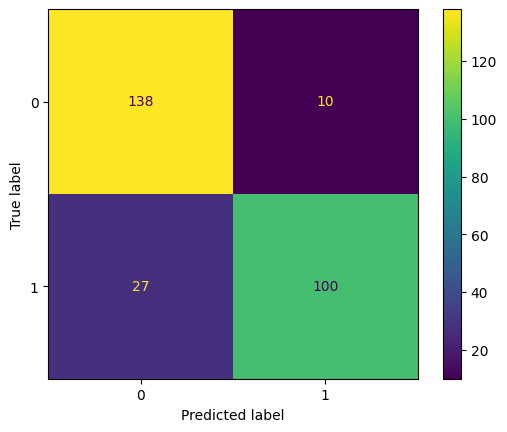

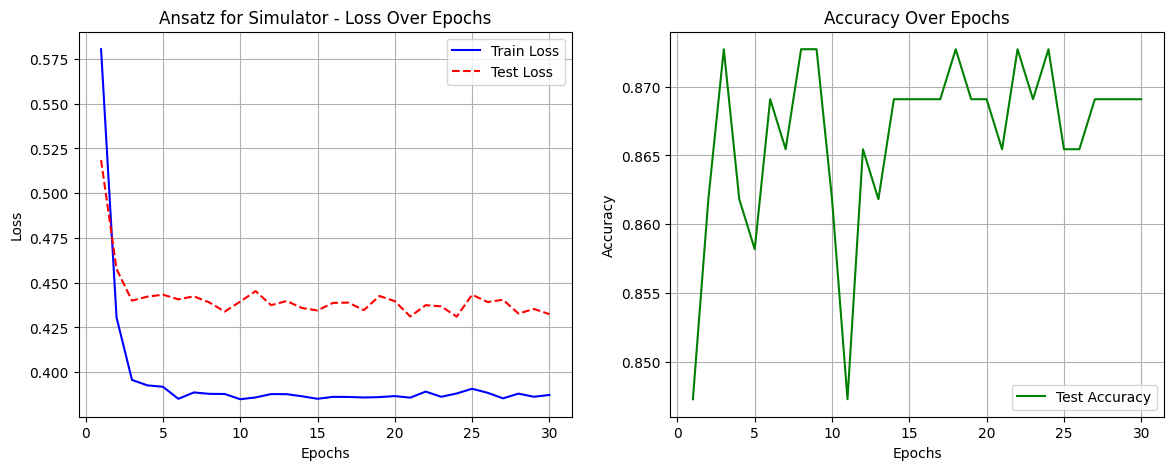

F1 SCORE:  0.8438818565400844  | ACCURACY SCORE:  0.8654545454545455


In [11]:
with torch.no_grad():
    test_outputs_tensor = model(X_test_tensor)
    test_outputs = test_outputs_tensor.numpy()

predicted = np.where(test_outputs > 0, 1, -1).flatten()

c_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predicted))
c_matrix_display.plot()

epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(14, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Train Loss', color='blue')
plt.plot(epochs, test_loss_history, label='Test Loss', color='red', linestyle='--')
plt.title('Ansatz for Simulator - Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_acc_history, label='Test Accuracy', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

print("F1 SCORE: ", f1_score(y_test, predicted), " | ACCURACY SCORE: ", accuracy_score(y_test, predicted))